# COMP47670 Assignment II Autumn 2023
## Time Series Running Data

## Objective
The objective of this assignment is to identify good models for classifying time series data.  
The data is from an accelerometer sensor and there are samples of fatigued and non-fatigued running. The data has been segmented into strides and the segments (samples) are labelled F (fatigued) and NF (not fatigued). The data for two subjects A and B are available in the files  `fatigueA.csv` and  `fatigueB.csv`. This dataset is extracted from a much larger dataset described [here](https://openreview.net/pdf?id=9c0lAonDNP).  
At present, the best performing method for time-series classification is [Rocket](https://openreview.net/pdf?id=9c0lAonDNP). 
A rocket implementation is available in the [sktime tool kit](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.rocket.Rocket.html). This sktime implementation can be used in this assignment.   
Some code to get you started in available in the notebook `RunningCore`.



In [1]:
# pip install sktime

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sktime.transformations.panel.rocket import Rocket
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [72]:
fatigue_df = pd.read_csv('fatigueA.csv', header = None) # sep = '\s+')
print(fatigue_df.shape)
fatigue_df

(421, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,F,2.72,2.69,2.750,2.890,3.07,3.27,3.48,3.67,3.82,...,6.50,6.16,5.75,5.29,4.79,4.29,3.83,3.42,3.09,2.85
1,F,2.68,2.47,2.460,2.540,2.69,2.93,3.36,3.99,4.75,...,2.79,3.88,5.18,6.29,6.88,6.80,6.13,5.11,4.04,3.20
2,F,5.04,5.69,6.210,6.520,6.59,6.47,6.26,6.06,5.91,...,5.89,5.29,4.72,4.20,3.77,3.47,3.36,3.47,3.82,4.38
3,F,2.42,3.21,4.020,4.580,4.77,4.64,4.39,4.25,4.42,...,8.60,8.76,8.76,8.32,7.34,5.91,4.33,2.97,2.14,1.98
4,F,3.35,3.40,3.890,4.710,5.66,6.47,6.90,6.81,6.25,...,9.45,8.52,7.75,7.14,6.63,6.15,5.60,4.96,4.28,3.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,NF,2.37,3.17,3.810,4.180,4.32,4.42,4.68,5.27,6.17,...,6.41,6.24,5.91,5.26,4.27,3.11,2.07,1.39,1.26,1.64
417,NF,2.42,1.86,1.910,2.640,3.84,5.11,6.02,6.29,5.93,...,7.45,5.94,4.63,3.85,3.68,3.96,4.32,4.41,4.04,3.28
418,NF,2.17,1.45,1.850,3.430,5.69,7.76,8.86,8.69,7.60,...,8.58,8.57,7.83,6.84,6.08,5.75,5.69,5.46,4.73,3.49
419,NF,2.07,1.16,0.671,0.737,1.37,2.46,3.84,5.33,6.78,...,8.02,7.08,6.45,6.14,6.04,5.96,5.71,5.16,4.29,3.19


Text(0, 0.5, 'Accel Mag')

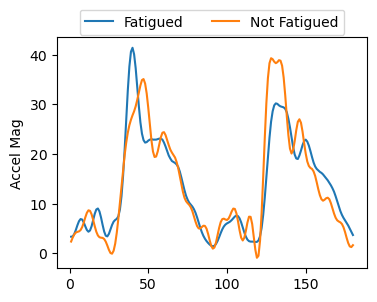

In [73]:
fatigue_df.iloc[4][1:].plot(label='Fatigued')
fatigue_df.iloc[-5][1:].plot(figsize=(4,3), label = 'Not Fatigued')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)
plt.ylabel('Accel Mag')

In [74]:
y = fatigue_df.pop(0).values
X = fatigue_df.values

### Task 1
Calculate the accuracy of a logistic regression classifier (`SGDClassifier`) on the raw time series data for subject A. 

In [75]:
X.shape, y.shape

((421, 180), (421,))

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SGDClassifier(random_state=42)
clf.fit(X_train, y_train)

cv_scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
print("Cross-validation accuracy:", round(cv_scores.mean(), 4))

y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(test_accuracy, 4))

Cross-validation accuracy: 0.815
Test accuracy: 0.8824


The baseline accuracy using the SGDClassifier for subject A is 81.5% on the training set and 88.24% accuracy on the test dataset.

### Task 2
The RunningCore Notebook contains code to convert the data to the `sktime` time-series format. Using this format assess the accuracy of the Rocket transformer coupled with an `SGDClassifier` classifier on the data for subject A. 


In [102]:
X3d = X[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)
X3d.shape

pipe = make_pipeline(
    Rocket(random_state=42), SGDClassifier(random_state=42)
)

X_train, X_test, y_train, y_test = train_test_split(X3d, y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(pipe, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
print("Cross-validation accuracy:", round(cv_scores.mean(), 4))

pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)
print("Test accuracy:", round(accuracy, 4))

/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages

Cross-validation accuracy: 0.8923
Test accuracy: 0.9765


The accuracy using rocket and the SGDClassifier is 89.23% on the training and 97.65% on the test dataset. This is a substantial improvement compared to Task 1, which only used the SGDClassifier.

### Task 3
Evaluate alternatives to see if you can improve the accuracy on the raw data (Task 1). For this, you should consider alternative classifiers and data normalisation. The data should not be transformed beyond normalisation. 

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    "passthrough"
]

clfs = [
    SGDClassifier(random_state=42),
    RidgeClassifier(random_state=42),
    LogisticRegression(max_iter=10000, random_state=42),
    SVC(random_state=42),
    DecisionTreeClassifier(random_state=42),
    KNeighborsClassifier()
]

pipe = Pipeline([
    ("scaler", scalers),
    ("clfs", clfs)
])

param = {
    "scaler": scalers,
    "clfs": clfs
}

grid = GridSearchCV(
    pipe,
    param_grid=param,
    scoring="accuracy",
    verbose=1,
    cv=10,
    n_jobs=-1
)

grid.fit(X_train, y_train)
y_pred_gs = grid.predict(X_test)
print(grid.best_params_)
print("Test Accuracy for best parameters: {0:4.4f}".format(accuracy_score(y_test, y_pred_gs)))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'clfs': SVC(random_state=42), 'scaler': StandardScaler()}
Test Accuracy for best parameters: 0.9647


In [108]:
pd.DataFrame(grid.cv_results_)[['rank_test_score', 'mean_test_score', 'std_test_score', 'param_clfs', 'param_scaler']].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,std_test_score,param_clfs,param_scaler
15,1,0.892602,0.039072,SVC(random_state=42),StandardScaler()
25,2,0.881194,0.043228,KNeighborsClassifier(),StandardScaler()
27,3,0.878164,0.059355,KNeighborsClassifier(),MaxAbsScaler()
26,3,0.878164,0.064923,KNeighborsClassifier(),MinMaxScaler()
16,5,0.877807,0.051407,SVC(random_state=42),MinMaxScaler()
9,6,0.874688,0.062728,RidgeClassifier(random_state=42),passthrough
5,7,0.871747,0.058724,RidgeClassifier(random_state=42),StandardScaler()
8,8,0.868717,0.055868,RidgeClassifier(random_state=42),RobustScaler()
6,9,0.868627,0.054717,RidgeClassifier(random_state=42),MinMaxScaler()
7,9,0.868627,0.054717,RidgeClassifier(random_state=42),MaxAbsScaler()


SVC in combination with the StandardScaler is ranked 1. It achieved 89.26% mean accuracy on the training set and 96.47% accuracy on the test set.
On the 2nd and 3rd place is the kNN Classifier with 88.12% and 87.82% mean accuracy on the training set respectively. 

### Task 4
Evaluate alternatives to improve accuracy using the Rocket transformer. Test the Rocket transformer with different numbers of kernels. Consider alternative models for the classifier stage. Again, only the data for subject A should be considered. What conclusions can you draw?


In [105]:
X3d = X[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)

X_train, X_test, y_train, y_test = train_test_split(X3d, y, test_size=0.2, random_state=42)

clfs = [
    SGDClassifier(random_state=42),
    RidgeClassifier(random_state=42),
    #LogisticRegression(max_iter=10000),
    SVC(random_state=42),
    #DecisionTreeClassifier(),
    KNeighborsClassifier()
]

pipe = Pipeline([
    ("rocket", Rocket(random_state=42)),
    ("clfs", clfs)
])

param = {
    "clfs": clfs,
    "rocket__num_kernels": np.geomspace(1000, 50000, 10)
}

grid = GridSearchCV(
    pipe,
    param_grid=param,
    scoring="accuracy",
    verbose=0,
    cv=10,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print(grid.best_params_)
accuracy = grid.score(X_test, y_test)
print("Test Accuracy for best parameters:", round(accuracy, 4))

/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_spar

{'clfs': RidgeClassifier(random_state=42), 'rocket__num_kernels': 20961.44000826768}
Test Accuracy for best parameters: 0.9647


In [106]:
pd.DataFrame(grid.cv_results_)[['rank_test_score', 'mean_test_score', 'std_test_score', 'param_clfs', 'param_rocket__num_kernels']].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,std_test_score,param_clfs,param_rocket__num_kernels
17,1,0.976292,0.017710,RidgeClassifier(random_state=42),20961.440008
18,2,0.973351,0.015876,RidgeClassifier(random_state=42),32373.940143
13,3,0.967380,0.024620,RidgeClassifier(random_state=42),3684.031499
16,4,0.964349,0.022160,RidgeClassifier(random_state=42),13572.088083
19,5,0.964349,0.011593,RidgeClassifier(random_state=42),50000.0
15,5,0.964349,0.011593,RidgeClassifier(random_state=42),8787.639344
14,7,0.958467,0.019572,RidgeClassifier(random_state=42),5689.810203
11,8,0.958200,0.027472,RidgeClassifier(random_state=42),1544.452105
12,9,0.949554,0.029431,RidgeClassifier(random_state=42),2385.332304
10,10,0.946435,0.029049,RidgeClassifier(random_state=42),1000.0


RidgeClassifier with 20961 kernels achieved with 97.63% accuracy on the training dataset the highest accuracy and is ranked 1st. It achieved 96.47% accuracy on the test dataset, showing very little variation.
In general, RidgeClassifier provides the best results by a margin because ranks 2-10 are also the RidgeClassifier but with different numbers of kernels for the rocket transformer. The second-best classifier is the SGDClassifier with its highest accuracy of 92.86% and 20961 was also found to be the best performing number of kernels for the rocket transformer. 
In comparison with the result of Task 2 (SGDClassifier with 89.23% on the training and 97.65% accuracy on test data) there is a large improvement on the training data (89.23 vs 97.63%) but slightly worse performance on the test data (97.65 vs 96.47%). By increasing the number of kernels to 20961, the accuracy on the train dataset was improved from 89.23 to 92.86%.

### Task 5
Test to see if the main conclusions from Tasks 3 and 4 hold up with the data for subject B. Comment on your findings. 

In [111]:
fatigue_df_b = pd.read_csv('fatigueB.csv', header = None) # sep = '\s+')
print(fatigue_df_b.shape)
fatigue_df_b

(251, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,F,1.49,4.09,9.27,12.70,12.80,12.00,12.40,13.20,13.00,...,9.53,9.30,9.61,9.25,8.07,7.62,8.76,9.61,7.63,3.57
1,F,7.35,7.25,7.80,7.94,7.34,6.48,5.87,5.47,5.20,...,8.92,7.66,7.76,8.28,8.99,10.20,11.60,11.90,10.70,8.72
2,F,9.31,9.06,9.41,9.51,9.23,9.14,9.08,8.45,7.63,...,11.40,10.50,9.63,9.29,9.75,10.20,10.10,10.10,10.20,10.00
3,F,9.82,10.50,9.86,10.20,10.90,10.60,9.97,9.50,8.15,...,11.50,10.60,9.07,7.65,6.83,6.67,6.28,5.09,4.77,7.00
4,F,4.68,3.68,4.63,5.01,4.05,3.40,4.00,4.62,4.25,...,11.90,10.60,11.10,12.90,14.00,13.60,13.00,12.80,11.50,8.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,NF,5.47,5.91,6.08,6.72,8.01,8.76,8.48,8.15,8.23,...,11.00,9.36,9.18,9.72,9.54,8.58,7.64,6.76,5.73,5.18
247,NF,4.79,5.81,6.82,7.60,8.36,9.01,9.19,9.04,8.79,...,13.70,12.90,11.80,9.63,7.22,5.84,5.64,5.63,5.09,4.53
248,NF,4.05,4.92,5.89,6.83,7.89,8.74,8.99,8.86,8.60,...,8.02,7.02,6.58,6.33,5.77,4.99,4.51,4.36,4.11,3.80
249,NF,3.98,4.71,4.72,5.26,6.18,6.55,7.01,7.75,7.50,...,7.68,7.50,6.54,5.74,5.45,5.12,4.64,3.91,2.97,2.90


Text(0, 0.5, 'Accel Mag')

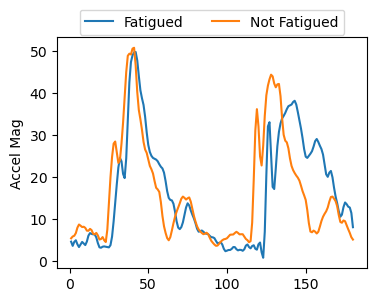

In [112]:
fatigue_df_b.iloc[4][1:].plot(label='Fatigued')
fatigue_df_b.iloc[-5][1:].plot(figsize=(4,3), label = 'Not Fatigued')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)
plt.ylabel('Accel Mag')

In [113]:
y_b = fatigue_df_b.pop(0).values
X_b = fatigue_df_b.values

#### Comparison with Task 3

In [123]:
def train_models(clf, scaler):
    X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
    pipe = make_pipeline(
        scaler,
        clf
    )
    print(clf, scaler)
    pipe.fit(X_train, y_train)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
    print("Cross-validation accuracy: {0:4.4f}".format(cv_scores.mean()))
    
    y_pred = pipe.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test accuracy: {0:4.4f}".format(test_accuracy))
    print()
    
    
model_subset = [
    [SVC(random_state=42), StandardScaler()],
    [LogisticRegression(max_iter=10000, random_state=42), "passthrough"],
    [DecisionTreeClassifier(random_state=42), MinMaxScaler()]
]

for clf, scaler in model_subset:
    train_models(clf, scaler)

SVC(random_state=42) StandardScaler()
Cross-validation accuracy: 0.9300
Test accuracy: 0.9020

LogisticRegression(max_iter=10000, random_state=42) passthrough
Cross-validation accuracy: 0.8000
Test accuracy: 0.8235

DecisionTreeClassifier(random_state=42) MinMaxScaler()
Cross-validation accuracy: 0.8800
Test accuracy: 0.7843


In order to test if the main conclusion from Task 3 hold up with data from subject B, I selected the following sample of configurations (classifier & scaler) based on their ranking in Task 3:

Best (1st): SVC with StandardScaler
Mid (15th): LogReg with passtrough
Worst (30th): DTree with MinMaxScaler
<br/>

The test accuracy on subject B data confirms the order from subject A data. This shows that general preference of the models and scalers is similar and one of the conclusion of Task 3 seems to be holding up.
Contrary, DTree yields much higher accuracy in cross-validation as LogReg on subject B data. This is represented by the following accuracy comparison between subject A and subject B data:

Subject A, Subject B
84.80%, 80% LogReg
78.55%, 88% DTree
<br/>

We also see slightly different results with SVC with StandardScaler as it achieved 89.26% in training for subject A and 93% for subject B. On test data it performed with an astonishing 96.47% accuracy for subject A and "only" 90% accuracy for subject B. Nevertheless, SVC with standardscaler is still the top performing model, regardless of subject A or B.

#### Comparison with Task 4 (Rocket)

In [124]:
def train_models_rocket(clf, num_kernels):
    X3d_b = X_b[:,np.newaxis,:]
    X_train, X_test, y_train, y_test = train_test_split(X3d_b, y_b, test_size=0.2, random_state=42)
    
    pipe = make_pipeline(
        Rocket(num_kernels=num_kernels, random_state=42),
        clf
    )
    pipe.fit(X_train, y_train)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
    print(clf, num_kernels)
    print("Cross-validation accuracy:", round(cv_scores.mean(), 4))

    y_pred = pipe.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test accuracy:", round(test_accuracy, 4))
    print()


model_subset = [
    [RidgeClassifier(random_state=42), 20961],
    [SVC(random_state=42), 3684],
    [SGDClassifier(random_state=42), 8787]
]

for clf, num_kernels in model_subset:
    train_models_rocket(clf, num_kernels)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)

RidgeClassifier(random_state=42) 20961
Cross-validation accuracy: 0.975
Test accuracy: 0.9608


/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_spar

SVC(random_state=42) 3684
Cross-validation accuracy: 0.94
Test accuracy: 0.8235


/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/timon/miniconda3/envs/ml_practical/lib/python3.11/site-packages

SGDClassifier(random_state=42) 8787
Cross-validation accuracy: 0.9
Test accuracy: 0.8431


In order to test if the main conclusion from Task 4 hold up with data from subject B, I selected the following sample of configurations (classifier & scaler) based on their ranking in Task 4:

Best (1st rank in task 4): RidgeClassifier with 20,961 kernels
Mid (20t rank in task 4): SVC with 3,684 kernels
Worst (40th rank in task 4): SGDClassifier with 8,787 kernels

Accuracy [in %] comparison in cross-validation (training) between subject A and subject B:
97.63 vs 97.5 Ridge => equal (within margin of error)
88.08 vs 94 SVC => much higher accuracy on subject B data
83.97 vs 90 SGDC => much higher accuracy on subject B data

The ranking of the different combinations is still holding up with subject B data. Interestingly, the cross-validation accuracy for subject B is much higher with SVC and SGDC and their respective number of kernels compared to subject A. 

Accuracy comparison in testing between subject A and subject B:
96.47 vs 96.08 Ridge => equal (within margin of error)